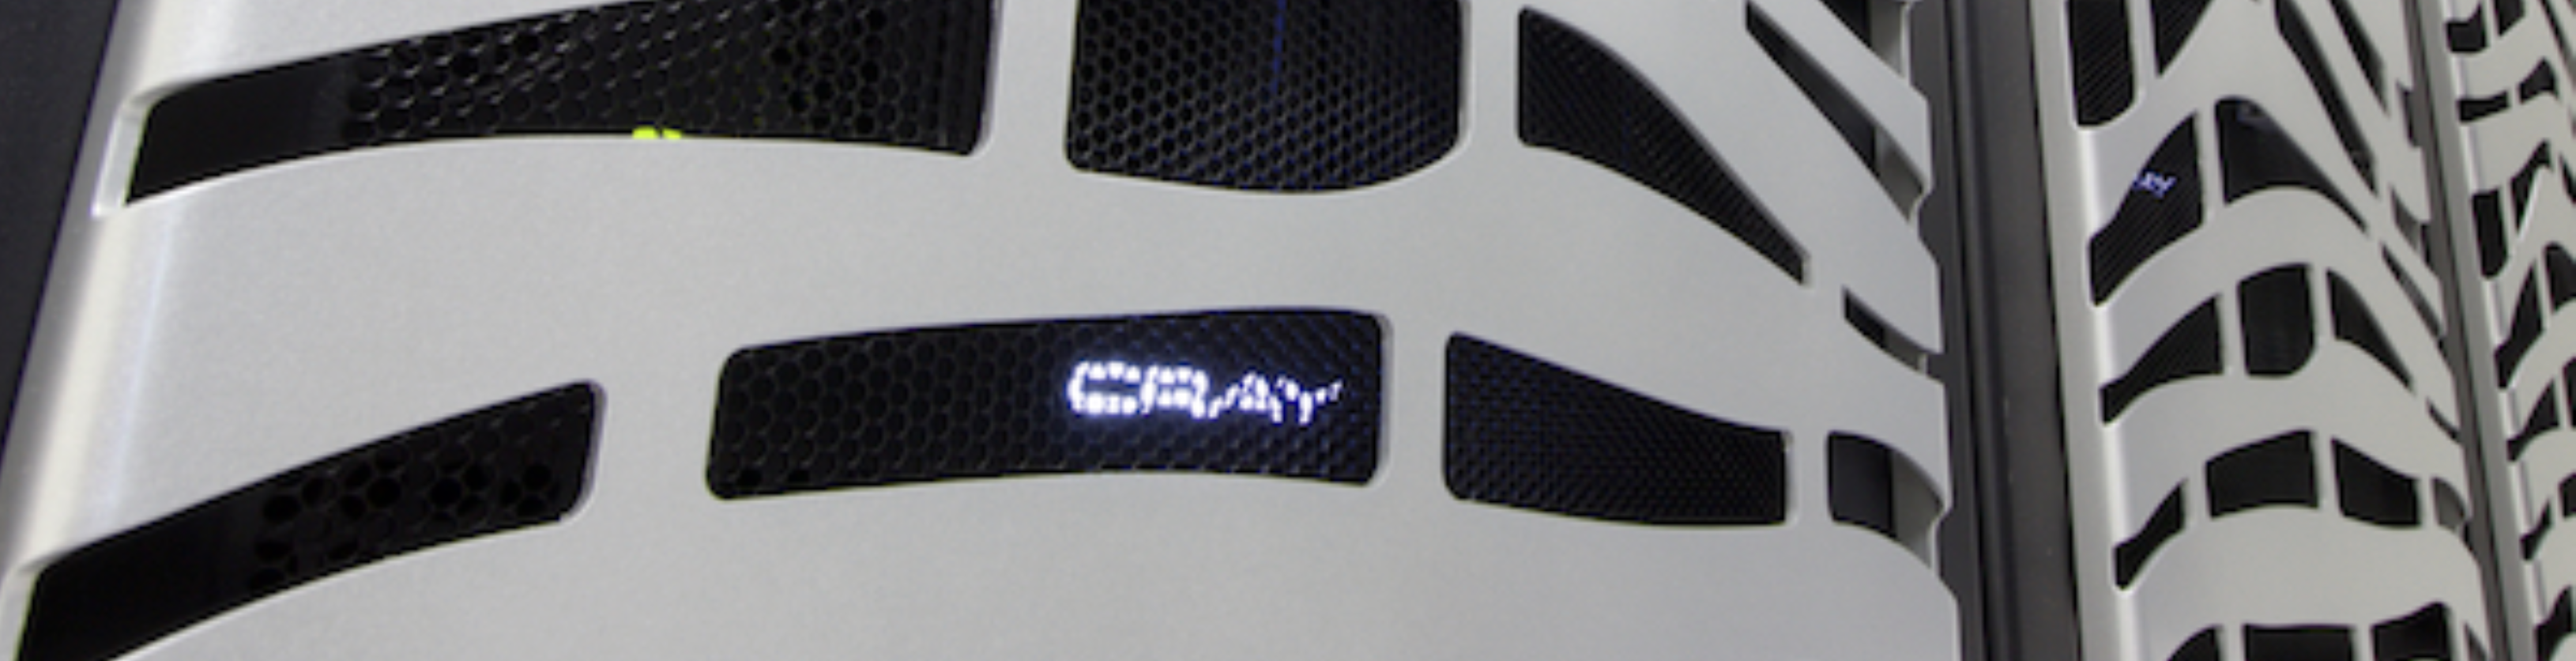

# Plot the performance for a set of simulations

## Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pathlib as pl
import flopy

In [ ]:
from performance import *
from plot_functions import *

## Set path for figures to be saved

In [ ]:
figure_path = pl.Path("figures")
figure_path.mkdir(parents=True, exist_ok=True)

## List the available json files in the `performance` directory

In [ ]:
list_available_json_files()

Get a list of available json files and load performance data from one of the json files

In [ ]:
json_files = get_available_json_files()
performance = load_performance_json(json_files[-1].name)

Plot the performance data

In [ ]:
if performance["metis"]:
    split_string = "_metis"
else:
    split_string = ""
if "simulation_type" in performance.keys():
    prepend_string = performance["simulation_type"]
else:
    prepend_string = performance["grid_type"]
figure_base_name = (
    f"{prepend_string}{split_string}_"
    + f"{performance['total_cells']:,}_"
    + f"{performance['active_cells']:,}_"
)
figure_title = (
    f"{prepend_string.replace('_', ' ').title()} "
    + f"-- {performance['total_cells']:,} "
    + f"Total Cells {performance['active_cells']:,} Active Cells"
)

In [ ]:
axd = plt.figure(
    layout="constrained",
    figsize=(figwidth, figheight * 0.9),
).subplot_mosaic(
    """
    ab
    cd
    """,
    empty_sentinel="X",
    sharex=True,
)

timing_data = {
    "a": performance["mean_runtimes"],
    "b": performance["max_iterations"],
    "c": performance["mean_formulatetimes"],
    "d": performance["mean_solutiontimes"],
}
ylabels = {
    "a": "Runtime (sec)",
    "b": "Number of iterations",
    "c": "Formulation time (sec)",
    "d": "Solution time (sec)",
}
plotlabels = {
    "a": "Runtime",
    "b": "Inner iterations",
    "c": "Formulation time",
    "d": "Solution time",
}

for idx, key in enumerate(axd.keys()):
    ax = axd[key]
    p1 = ax.plot(
        performance["processors"],
        timing_data[key],
        lw=0.5,
        color="black",
        marker="o",
        ms=4,
        mfc="none",
        mec="black",
        label=plotlabels[key],
    )
    ax.set_ylabel(ylabels[key])
    if key in ("c", "d"):
        ax.set_xlabel("Number of CPUs")
    if key == "b":
        if "outer_iterations" in performance.keys():
            ax.yaxis.set_major_locator(MaxNLocator(integer=True))
            axt = ax.twinx()
            p2 = axt.plot(
                performance["processors"],
                np.array(performance["outer_iterations"], dtype=int),
                lw=0.5,
                color="0.5",
                ls=":",
                marker=".",
                ms=4,
                mfc="none",
                mec="black",
                label="Outer iterations",
            )
            axt.set_ylabel("Outer iterations")
            axt.yaxis.set_major_locator(MaxNLocator(integer=True))
            lns = p1 + p2
            labs = [l.get_label() for l in lns]
            ax.legend(lns, labs, loc="upper left", frameon=False)

fig = plt.gcf()
fig.suptitle(figure_title)

fname = figure_path / f"{figure_base_name}timing.pdf"
fig.savefig(fname);

In [ ]:
cpu_range = (performance["processors"][0], performance["processors"][-1])

axd = plt.figure(
    layout="constrained",
    figsize=(figwidth, figheight * 0.9),
).subplot_mosaic(
    """
    ab
    cd
    """,
    empty_sentinel="X",
    sharex=True,
)

speedup_data = {
    "a": performance["formulate_speedup"],
    "b": performance["solution_speedup"],
    "c": performance["speedup"],
    "d": performance["max_memory_usage"],
}
ylabels = {
    "a": "Formulate Speedup",
    "b": "Solution Speedup",
    "c": "Total Runtime Speedup",
    "d": "Maximum Memory Usage (GB)",
}
legend_labels = {
    "a": None,
    "b": None,
    "c": None,
    "d": "Maximum",
}

for idx, key in enumerate(axd.keys()):
    ax = axd[key]
    ax.plot(
        performance["processors"],
        speedup_data[key],
        lw=0.5,
        color="black",
        marker="o",
        ms=4,
        mfc="none",
        mec="black",
        label=legend_labels[key],
    )
    if key != "d":
        ax.plot(
            cpu_range, cpu_range, ls="--", lw=0.5, color="0.5", label="ideal"
        )
    elif key == "d":
        if "max_non_virtual_memory_usage" in performance.keys():
            plot_virtual_memory(
                ax,
                performance["processors"],
                speedup_data[key],
                performance["max_non_virtual_memory_usage"],
            )

    ax.set_ylabel(ylabels[key])
    if key in ("c", "d"):
        ax.set_xlabel("Number of CPUs")
    ax.set_xlim(cpu_range)
    if key != "d":
        ax.set_ylim(cpu_range)
    if key == "a":
        ax.legend(frameon=False)

fig = plt.gcf()
fig.suptitle(figure_title)

fname = figure_path / f"{figure_base_name}speedup.pdf"
fig.savefig(fname);

In [ ]:
axd = plt.figure(
    layout="constrained", figsize=(figwidth, figheight / 2)
).subplot_mosaic(
    """
    ab
    """,
    empty_sentinel="X",
)

memory_data = {
    "a": performance["total_memory_usage"],
    "b": performance["max_memory_usage"],
}
ylabels = {"a": "Total Memory Usage (GB)", "b": "Maxmimum Memory Usage (GB)"}
legend_labels = {
    "a": "Total",
    "b": "Maximum",
}
if "max_non_virtual_memory_usage" in performance.keys():
    non_virtual_data = {
        "a": performance["total_non_virtual_memory_usage"],
        "b": performance["max_non_virtual_memory_usage"],
    }

for idx, key in enumerate(axd.keys()):
    ax = axd[key]
    ax.plot(
        performance["processors"],
        memory_data[key],
        lw=0.5,
        color="black",
        marker="o",
        ms=4,
        mfc="none",
        mec="black",
        label=legend_labels[key],
    )
    if "max_non_virtual_memory_usage" in performance.keys():
        plot_virtual_memory(
            ax,
            performance["processors"],
            memory_data[key],
            non_virtual_data[key],
        )

    ax.set_ylabel(ylabels[key])
    ax.set_xlabel("Number of CPUs")
    ax.set_xlim(cpu_range)

fig = plt.gcf()
fig.suptitle(figure_title)

fname = figure_path / f"{figure_base_name}memory.pdf"
fig.savefig(fname);